# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

*The project goal* is to combine transaction, demographic and offer data to **determine which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# A. Project Deliverables 

1. Identify which groups of people are most responsive to each type of offer  
2. What type offers really excite people?
3. How best to present each type of offer?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, OPTICS
from yellowbrick.cluster.elbow import kelbow_visualizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# B. Data Wrangling 

## B1. Import data sets

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# offers portfolio
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# customers profiles
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
# records of transactions
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Note**
- profile and transcript share: user (id and person)
- portfolio and transcript share: offer id

**Action**
- create dummy variables where data type is complicated 
- rename columns for simplifying and merging purposes
- change data types where applicable (e.g. time in days)

## B2. Portfolio

In [6]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


**Note**
- There are 10 unique offer ids, associating with 3 types of offers
- rename the 'id' column to 'offer_id'
- dummy 'channels' and 'offer_type' columns

In [9]:
# change id column name to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# dummy the channels column
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)

# drop the orignial channel column and concatenate the dummies ones
portfolio = pd.concat([portfolio,channel_dummies],axis=1)
portfolio.drop('channels', axis=1, inplace=True)

# dummy the offer_type column
offer_dummy = pd.get_dummies(portfolio['offer_type'])

# concatenate back to 'portfolio' df
portfolio = pd.concat([portfolio,offer_dummy],axis=1)

portfolio

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [10]:
print('Types of offers:',portfolio['offer_type'].unique())
print('Numbers of unique offer ids:',portfolio['offer_id'].nunique())
print('Types of advertising channels: email, mobile, social, web')

Types of offers: ['bogo' 'informational' 'discount']
Numbers of unique offer ids: 10
Types of advertising channels: email, mobile, social, web


## B2. Profile

In [11]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

<AxesSubplot:>

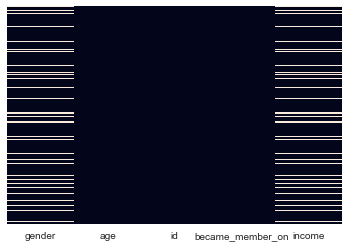

In [14]:
sns.heatmap(profile.isnull(),yticklabels=False,cbar=False)

**__ Insights __**
- rename 'id' to'customer id'
- the same incomplete profiles are missing 'gender' and 'income' info
    - can compute 'income' relative to age range
    - can compute 'gender' into M/F/Unspecified -> dummy
- age: max is 118
    - explore the values, then replace irregular values with appropriate values
    - can group the age into different buckets
- convert 'became_member_on' to date format
    - also consider if year is informative enough -> dummy

### B2.a. Time joined the app

In [15]:
# rename 'id' to 'customer_id'
profile.rename(columns={'id':'customer_id'},inplace=True)

# convert date format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


### B2.b. Gender

In [16]:
# gender values
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [17]:
# fill missing values with 'unspecified'
profile['gender'] = profile['gender'].fillna('Unspecified')

profile.head()

,gender,age,customer_id,became_member_on,income
0,Unspecified,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,Unspecified,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,Unspecified,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [18]:
profile['gender'].value_counts()

M              8484
F              6129
Unspecified    2175
O               212
Name: gender, dtype: int64

In [19]:
gender = pd.get_dummies(profile['gender'])
gender.head()

,F,M,O,Unspecified
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,1,0,0,0
4,0,0,0,1


In [20]:
profile = pd.concat([profile, gender],axis=1)
profile.head()

,gender,age,customer_id,became_member_on,income,F,M,O,Unspecified
0,Unspecified,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,0
2,Unspecified,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,0
4,Unspecified,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,1


### B2.c. Age and Income

In [21]:
# Age stats
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [22]:
# number of unique age
profile['age'].nunique()

85

In [23]:
# unique age
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [24]:
profile['age'].value_counts().sort_index()

18       70
19      135
20      135
21      140
22      131
       ... 
98        5
99        5
100      12
101       5
118    2175
Name: age, Length: 85, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Density'>

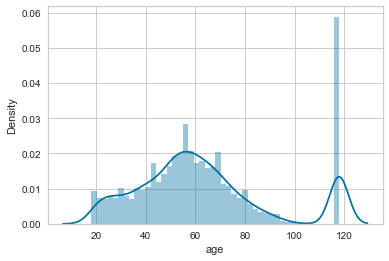

In [25]:
# Distribution of customer age
sns.distplot(profile['age'])

In [26]:
# Income Stats
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

<AxesSubplot:xlabel='income', ylabel='Density'>

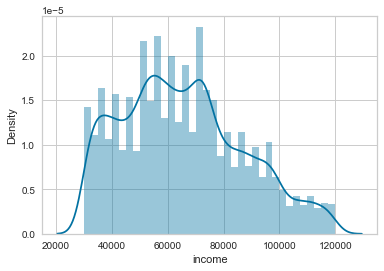

In [27]:
# Income distribution
sns.distplot(profile['income'])

**__ Insights __**
- Can I consider age of 100, 101 and 118 are abnormal and drop them as outliers from analysis? 
- Outlier rule of thum is >3 std. 3std in age distribution: 3(26.74) = 80.22
- From income stats, the saraly min is 30K, max is 120K, average is 64K. It is reasonable to use the average income to compute for mising values.
- However, are the missing values associated with users who are older than 100 years old?

### B2.d. Abnormal age

In [28]:
abnorm_age = [100,101,118]
abnorm = profile[profile['age'].isin(abnorm_age)]

print(abnorm.shape)
abnorm.head()

(2192, 9)


,gender,age,customer_id,became_member_on,income,F,M,O,Unspecified
0,Unspecified,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,1
2,Unspecified,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,1
4,Unspecified,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,1
6,Unspecified,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,0,0,0,1
7,Unspecified,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,0,0,0,1


In [29]:
# portion of abnormal age in the dataset
abnorm.shape[0]/profile.shape[0]

0.12894117647058823

In [30]:
abnorm.groupby(['age','income']).count()

gender  customer_id  became_member_on  F  M  O  Unspecified
age income                                                               
100 42000.0        1            1                 1  1  1  1            1
    47000.0        1            1                 1  1  1  1            1
    63000.0        2            2                 2  2  2  2            2
    70000.0        1            1                 1  1  1  1            1
    71000.0        2            2                 2  2  2  2            2
    83000.0        1            1                 1  1  1  1            1
    96000.0        1            1                 1  1  1  1            1
    98000.0        1            1                 1  1  1  1            1
    109000.0       1            1                 1  1  1  1            1
    118000.0       1            1                 1  1  1  1            1
101 43000.0        1            1                 1  1  1  1            1
    56000.0        1            1                 1  1  1  1            1
    59000.0        1            1                 1  1  1  1            1
    82000.0        1            1                 1  1  1  1            1
    99000.0        1            1                 1  1  1  1            1

In [31]:
abnorm['income'].nunique()

15

**Questions:** 
- are all 118-yr users don't have income?
- are all NaN income from profile df associates with 118-yr users?
- what is the percentage of 118-yr user in the df?

<AxesSubplot:>

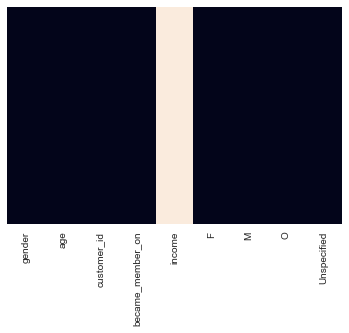

In [32]:
# yes, all 118-yr users don't have income
sns.heatmap(abnorm.query('age == 118').isnull(),yticklabels=False,cbar=False)

In [33]:
# total 118-yr users
abnorm['age'].value_counts() # agreed with profile df

118    2175
100      12
101       5
Name: age, dtype: int64

In [34]:
# total nul values for income
abnorm['income'].isnull().sum() # agreed with profile df

2175

In [35]:
# what about their gender?
abnorm.groupby(['age','gender']).count() # agreed with profile df

customer_id  became_member_on  income     F     M     O  \
age gender                                                                 
100 F                      9                 9       9     9     9     9   
    M                      2                 2       2     2     2     2   
    O                      1                 1       1     1     1     1   
101 F                      5                 5       5     5     5     5   
118 Unspecified         2175              2175       0  2175  2175  2175   

                 Unspecified  
age gender                    
100 F                      9  
    M                      2  
    O                      1  
101 F                      5  
118 Unspecified         2175

In [36]:
# Portion of 118-yr users
percent118 = len(profile[profile['age']==118])/profile.shape[0]*100
percent118

12.794117647058822

### B2.e. Findings on Profile dataset

In [37]:
print('There are {} users who are 118 years old.'.format(abnorm['age'].value_counts()[118]))
print('There are {} users who do not provide income.'.format(profile['income'].isnull().sum()))
print('There are {} users who do not provide gender.'.format(abnorm[abnorm['gender']=='Unspecified'].shape[0]))
print('Percentage of people whose age is 118 is: {}%'.format(round(percent118,2)))
print('Percentage of people who is older than 100 is: {}%'.format(round(abnorm.shape[0]/profile.shape[0]*100, 2)))

There are 2175 users who are 118 years old.
There are 2175 users who do not provide income.
There are 2175 users who do not provide gender.
Percentage of people whose age is 118 is: 12.79%
Percentage of people who is older than 100 is: 12.89%


After exploring the data, I conclude that the abnormal users have these attributes:
- 118 years old 
- don't have income
- gender is unspecified

I consider all users who are older than 100 years old as outliers since these ages are greater than 3 std.dev in age distribution, and there is not a significant amount difference (0.10%) of 118-yr vs greater than 100-yr sample sizes. Therefore, 
- I'm not going to compute missing income
- I'm going to remove them from the data set later after merging all data sets

## B3. Transcript

Data description
- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
- offer id: (string/hash) not associated with any "transaction"
- amount: (numeric) money spent in "transaction"
- reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

In [38]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [39]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [40]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**Note**
- rename 'person' to 'customer_id'
- convert time from hour to day
- dummy 'event' and 'value' 

### B3.a. Time

In [41]:
# rename 'person' to 'customer_id'
transcript.rename(columns={'person':'customer_id'},inplace=True)

# convert time
transcript['day'] = transcript['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
transcript.drop('time',axis=1,inplace=True)

transcript

,customer_id,event,value,day
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},30


<AxesSubplot:xlabel='day', ylabel='Density'>

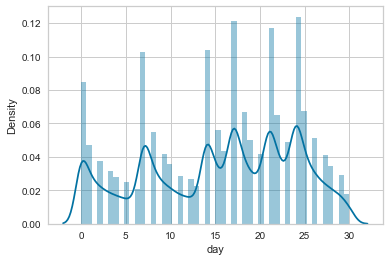

In [42]:
# time distribution
sns.distplot(transcript['day'])

### B3.b. Event

In [43]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

How does each evennt's entry look like?

In [44]:
# offer received
transcript.query('event == "offer received"').head()

,customer_id,event,value,day
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [45]:
# offer viewed
transcript.query('event == "offer viewed"').head()

,customer_id,event,value,day
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [46]:
# offer completed
transcript.query('event == "offer completed"').head()

,customer_id,event,value,day
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [47]:
# In offer completed, the value column seems to contain lengthy value
transcript[transcript['event']=='offer completed']['value'][12658]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [48]:
# transaction
transcript.query('event == "transaction"').head()

,customer_id,event,value,day
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


**Insights**
- For "received and viewed" envents, there are only offer id.
    - E.g: {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
- For "completed" event, there are record of the offer id and its value (dollars). Note the underscore **"offer_id"**
    - E.g.: {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}
- For "transaction" event, there is record of the amount spent (dollars)
    - E.g: {'amount': 34.56}

### B3.c. Value: {'offer' : 'offer value'}

In [49]:
transcript['value'] # it contains many dictionaries

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [50]:
# What are the keys of 'offer'? 
def uniqueKeys(arr):
    key = list(set(key for dic in arr for key in dic.keys()))
    return key

uniqueKeys(transcript['value'])

['offer id', 'reward', 'offer_id', 'amount']

**Note**: 
- each offer_id associates with a reward (see portfolio df), and is "completed" event
- can bypass recording reward at this step because this information can publish by merging with portfolio df later

In [51]:
# create 'offer_id' col
transcript['offer_id'] = [list(x.values())[0]  if (list(x.keys())[0] in ['offer_id', 'offer id']) else np.nan for x in transcript['value']]
# create 'amount' col
transcript['amount'] = [list(x.values())[0]  if (list(x.keys())[0] in ['amount']) else np.nan for x in transcript['value']]

transcript.head()

,customer_id,event,value,day,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [52]:
# drop the 'value' column
transcript.drop(columns=['value'],inplace=True)
transcript.head()

,customer_id,event,day,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### B3.d. Splitting transactions and offers groups

In [53]:
print(portfolio.shape)
portfolio

(10, 12)


,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [54]:
print(profile.shape)
profile.head()

(17000, 9)


,gender,age,customer_id,became_member_on,income,F,M,O,Unspecified
0,Unspecified,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,0
2,Unspecified,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,0
4,Unspecified,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,1


In [55]:
print(transcript.shape)
transcript.head()

(306534, 5)


,customer_id,event,day,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Transactions group

In [56]:
# query transaction event
transactions = transcript.query('event == "transaction"').copy()
transactions.head()

,customer_id,event,day,offer_id,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18.97


In [57]:
# merge with profile df on 'customer_id'
transactions = transactions.merge(profile, left_on='customer_id', right_on='customer_id')

# remove abnormal age 
transactions = transactions.query('age < 100')

# drop 'event', 'offer_id', and 'Unspecified' gender 
transactions.drop(['event','offer_id', 'Unspecified'],axis=1, inplace=True)

print(transactions.shape)
transactions.head()

(123802, 10)


,customer_id,day,amount,gender,age,became_member_on,income,F,M,O
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20,2016-07-11,30000.0,1,0,0
1,02c083884c7d45b39cc68e1314fec56c,1,1.44,F,20,2016-07-11,30000.0,1,0,0
2,02c083884c7d45b39cc68e1314fec56c,1,4.56,F,20,2016-07-11,30000.0,1,0,0
3,02c083884c7d45b39cc68e1314fec56c,4,1.53,F,20,2016-07-11,30000.0,1,0,0
4,02c083884c7d45b39cc68e1314fec56c,4,0.50,F,20,2016-07-11,30000.0,1,0,0


### Offers group

In [58]:
# query offers event
offers = transcript.query('event != "transaction"').copy()

offers.head()

,customer_id,event,day,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [59]:
# merge with profile df on 'customer_id'
offers = offers.merge(profile, left_on='customer_id', right_on='customer_id')
# merge with portfolio df on 'offer_id'
offers = offers.merge(portfolio, left_on='offer_id', right_on='offer_id')

# remove abnormal age 
offers = offers.query('age < 100')

# drop 'amount' and 'Unspecified' gender
offers.drop(['amount', 'Unspecified'],axis=1, inplace=True)

print(offers.shape)
offers.head()

(148628, 22)


,customer_id,event,day,offer_id,gender,age,became_member_on,income,F,M,...,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,5,7,bogo,1,1,0,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,5,7,bogo,1,1,0,1,1,0,0


In [60]:
print('Numbers of entries in Transactions dataset:',transactions.shape[0])
print('Numbers of unique customers in Transactions dataset',transactions['customer_id'].nunique())
print('\nNumbers of entries in Offers dataset:',offers.shape[0])
print('Numbers of unique customers in Offers dataset',offers['customer_id'].nunique())

Numbers of entries in Transactions dataset: 123802
Numbers of unique customers in Transactions dataset 14475

Numbers of entries in Offers dataset: 148628
Numbers of unique customers in Offers dataset 14803


In [61]:
# merge the 2 dataframes
off_tran = offers.merge(transactions,on='customer_id', how='outer')

print(off_tran.shape)
off_tran.head()

(1329671, 31)


,customer_id,event,day_x,offer_id,gender_x,age_x,became_member_on_x,income_x,F_x,M_x,...,informational,day_y,amount,gender_y,age_y,became_member_on_y,income_y,F_y,M_y,O_y
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1.0,0.0,...,0.0,6.0,19.89,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1.0,0.0,...,0.0,6.0,17.78,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1.0,0.0,...,0.0,10.0,19.67,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1.0,0.0,...,0.0,10.0,29.72,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1.0,0.0,...,0.0,16.0,23.93,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0


In [62]:
off_tran['customer_id'].nunique()

14808

In [63]:
trans_cust = transactions['customer_id'].unique()
offers_cust = offers['customer_id'].unique()

In [64]:
# Do all customers making purchases receive offers?
trans_in_offers = np.isin(trans_cust,offers_cust)
ar_unique, i = np.unique(trans_in_offers, return_counts=True)
print(ar_unique)
print(i)

[False  True]
[    5 14470]


In [65]:
# Do all customers receiveing offers make purchases?
offers_in_trans = np.isin(offers_cust,trans_cust)
ar_unique1, i1 = np.unique(offers_in_trans, return_counts=True)

print(ar_unique1)
print(i1)

[False  True]
[  333 14470]


**__ Insights __**
- There are 5 customers purchased without ever receiving offers
- There are 333 customers received offers but didn't make any purchases 

This makes senses because there are **14803 customers received offers**, and **5 customers never receive offers** but make purchases. So totally there are **14808 unique customers**.

## Thoughts Process for Analysis

The numbers of unique customers in the 3 dataframes above indicate that there are **14808 customers in this test**. They make purchases either after interacting (receive, view, complete) with promotional offers or without knowledge of offers. 

Therefore, I need to do some more data wrangling to *remove duplicates* and *consolidate* all the information to a final dataframe. **This dataframe will contain unique customers, their information, their associated purchases, and offers interactions if any.** 

1. Transactions group:
    - Have amount spent
    - Do not have offer_id, offer_type, or rewards
    - Records of customers making purchases with or without using offers
    - Can study the group spending habit and demographic <br>

2. Offers group:
    - Compute view_rate 
    - Compute complete_rate
    - Compute conversion_rate: view then complete
    - How these rates correlates with customers' demographic ?
    - How conversion rate is impacted by the type of offer, offer's source ? 

**Recall project deliveriables**
- customer segmentations
- types of offers that work when intergrating with customers' demographics
- is there a model to predict which customer should receive offers?

## B4. Data Wrangling (cont.)

### B4.a. Transactions group

In [66]:
transactions.head()

,customer_id,day,amount,gender,age,became_member_on,income,F,M,O
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20,2016-07-11,30000.0,1,0,0
1,02c083884c7d45b39cc68e1314fec56c,1,1.44,F,20,2016-07-11,30000.0,1,0,0
2,02c083884c7d45b39cc68e1314fec56c,1,4.56,F,20,2016-07-11,30000.0,1,0,0
3,02c083884c7d45b39cc68e1314fec56c,4,1.53,F,20,2016-07-11,30000.0,1,0,0
4,02c083884c7d45b39cc68e1314fec56c,4,0.50,F,20,2016-07-11,30000.0,1,0,0


<AxesSubplot:>

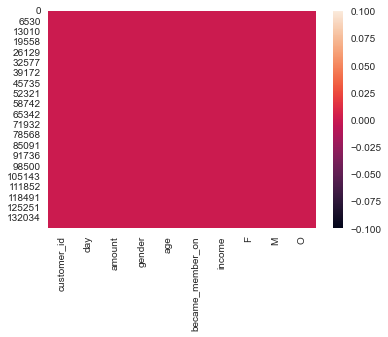

In [67]:
sns.heatmap(transactions.isnull())

**Note**
1. time (int) - time in hours since start of test. The data begins at time t=0 -> Change name to 'day'
2. Frequency: how many times the customers make purchases
3. Recency: the 'day' column represents number of days after the test starts (t=0). 
    - Recency of purchase will the be most recent day (aka the max days after t0)
4. Monetary value: total amount a customer spent

In [68]:
transactions[transactions.duplicated('customer_id')].head(10)

,customer_id,day,amount,gender,age,became_member_on,income,F,M,O
1,02c083884c7d45b39cc68e1314fec56c,1,1.44,F,20,2016-07-11,30000.0,1,0,0
2,02c083884c7d45b39cc68e1314fec56c,1,4.56,F,20,2016-07-11,30000.0,1,0,0
3,02c083884c7d45b39cc68e1314fec56c,4,1.53,F,20,2016-07-11,30000.0,1,0,0
4,02c083884c7d45b39cc68e1314fec56c,4,0.50,F,20,2016-07-11,30000.0,1,0,0
5,02c083884c7d45b39cc68e1314fec56c,5,9.80,F,20,2016-07-11,30000.0,1,0,0
6,02c083884c7d45b39cc68e1314fec56c,6,4.10,F,20,2016-07-11,30000.0,1,0,0
7,02c083884c7d45b39cc68e1314fec56c,6,2.73,F,20,2016-07-11,30000.0,1,0,0
8,02c083884c7d45b39cc68e1314fec56c,9,1.22,F,20,2016-07-11,30000.0,1,0,0
9,02c083884c7d45b39cc68e1314fec56c,18,3.18,F,20,2016-07-11,30000.0,1,0,0
11,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2,21.55,M,42,2016-01-17,96000.0,0,1,0


In [69]:
transactions.groupby(['customer_id']).count()

,day,amount,gender,age,became_member_on,income,F,M,O
customer_id,,,,,,,,,
0009655768c64bdeb2e877511632db8f,8,8,8,8,8,8,8,8,8
0011e0d4e6b944f998e987f904e8c1e5,5,5,5,5,5,5,5,5,5
0020c2b971eb4e9188eac86d93036a77,8,8,8,8,8,8,8,8,8
0020ccbbb6d84e358d3414a3ff76cffd,12,12,12,12,12,12,12,12,12
003d66b6608740288d6cc97a6903f4f0,18,18,18,18,18,18,18,18,18
...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,11,11,11,11,11,11,11,11,11
fff7576017104bcc8677a8d63322b5e1,6,6,6,6,6,6,6,6,6
fff8957ea8b240a6b5e634b6ee8eafcf,5,5,5,5,5,5,5,5,5


**What to expect**: 

A dataframe in which each customer has one entry. This entry contains the customer information, the frequency of making purchase, the most recent time a purchased is made, and a total amount spent so far.

**Action**

Merge the 3 series (frequency, recency, total amount) on customer_id
- compute frequency, recency, total amount. There will be 3 series separately
- drop the duplicated customers from the transactions df
- join all 3 series

In [70]:
# frequency
frequency = transactions.groupby(['customer_id'])['customer_id'].count()
# recency
recency = transactions.groupby(['customer_id'])['day'].max()
# monetary 
monetary = transactions.groupby(['customer_id'])['amount'].sum()

In [71]:
# join recency, frequency, monetary value
rfm = pd.concat([recency,frequency,monetary],axis=1)
rfm.columns = ['recency','frequency','monetary value']
rfm.head()

,recency,frequency,monetary value
customer_id,,,
0009655768c64bdeb2e877511632db8f,29,8,127.60
0011e0d4e6b944f998e987f904e8c1e5,28,5,79.46
0020c2b971eb4e9188eac86d93036a77,30,8,196.86
0020ccbbb6d84e358d3414a3ff76cffd,28,12,154.05
003d66b6608740288d6cc97a6903f4f0,29,18,48.34


In [72]:
# drop the duplicates customers
transactions.drop_duplicates(subset='customer_id',inplace=True)
transactions.shape

(14475, 10)

In [73]:
# drop the original 'day' and 'amount' columns
transactions.drop(['day','amount'],axis=1,inplace=True)

# clean transactions_df
transactions = pd.merge(left=transactions, right=rfm, on='customer_id')
print(transactions.shape)
transactions.head()

(14475, 11)


,customer_id,gender,age,became_member_on,income,F,M,O,recency,frequency,monetary value
0,02c083884c7d45b39cc68e1314fec56c,F,20,2016-07-11,30000.0,1,0,0,18,10,29.89
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,M,42,2016-01-17,96000.0,0,1,0,23,12,320.48
2,54890f68699049c2a04d415abc25e717,M,36,2017-12-28,56000.0,0,1,0,29,7,118.85
3,b2f1cd155b864803ad8334cdf13c4bd2,F,55,2017-10-16,94000.0,1,0,0,24,8,195.35
4,fe97aa22dd3e48c8b143116a8403dd52,F,39,2017-12-17,67000.0,1,0,0,30,11,562.77


### B4.b. Offers group

In [74]:
offers.head()

,customer_id,event,day,offer_id,gender,age,became_member_on,income,F,M,...,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,5,7,bogo,1,1,0,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,5,7,bogo,1,1,0,1,1,0,0


<AxesSubplot:>

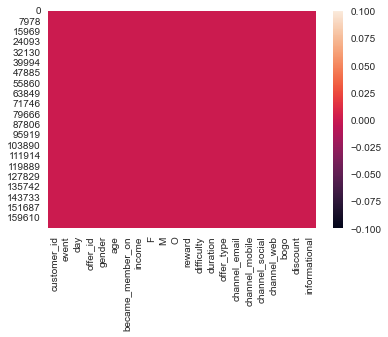

In [75]:
sns.heatmap(offers.isnull())

In [76]:
# the same offer can be received and viewed multiple times
offers[offers.duplicated(subset=['offer_id', 'customer_id'], keep=False)].head()

,customer_id,event,day,offer_id,gender,age,became_member_on,income,F,M,...,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,5,7,bogo,1,1,0,1,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,5,7,bogo,1,1,0,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,5,7,bogo,1,1,0,1,1,0,0


**Note**
- a customer can receive the same offer multiple times, and interact accordingly (received, viewed, completed)
- an offer can be received and viewed multiple times by a customer

**Actions**
- Dummy the 'event' column
- Identify duplicates on a subset of customer_id and offer_id

In [77]:
# dummy the 'event' col
event_dummies = pd.get_dummies(offers['event'])
# concatenate to the original df
offers = pd.concat([offers,event_dummies],axis=1)
offers.head()

,customer_id,event,day,offer_id,gender,age,became_member_on,income,F,M,...,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,1,1,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,1,1,0,0,0,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,1,1,0,0,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,1,1,0,1,1,0,0,0,1,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,1,1,0,1,1,0,0,0,0,1


In [78]:
offers.groupby(['customer_id','offer_id']).sum()

day  age  \
customer_id                      offer_id                                     
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5   48   66   
                                 3f207df678b143eea3cee63160fa8bed   30   66   
                                 5a8bc65990b245e5a138643cd4eb9837   15   66   
                                 f19421c1d4aa40978ebb69ca19b0e20d   54   99   
                                 fafdcd668e3743c1bb461111dcafc2a4   66   99   
...                                                                ...  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d   64  204   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7   24  135   
                                 2906b810c7d4411798c6938adc9daaa5  171  405   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9   65  135   
                                 fafdcd668e3743c1bb461111dcafc2a4    4  135   

                                                                     income  \
customer_id                      offer_id                                     
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  144000.0   
                                 3f207df678b143eea3cee63160fa8bed  144000.0   
                                 5a8bc65990b245e5a138643cd4eb9837  144000.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d  216000.0   
                                 fafdcd668e3743c1bb461111dcafc2a4  216000.0   
...                                                                     ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d  204000.0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7  186000.0   
                                 2906b810c7d4411798c6938adc9daaa5  558000.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9  186000.0   
                                 fafdcd668e3743c1bb461111dcafc2a4  186000.0   

                                                                   F  M  O  \
customer_id                      offer_id                                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  0  2  0   
                                 3f207df678b143eea3cee63160fa8bed  0  2  0   
                                 5a8bc65990b245e5a138643cd4eb9837  0  2  0   
                                 f19421c1d4aa40978ebb69ca19b0e20d  0  3  0   
                                 fafdcd668e3743c1bb461111dcafc2a4  0  3  0   
...                                                               .. .. ..   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d  0  6  0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7  3  0  0   
                                 2906b810c7d4411798c6938adc9daaa5  9  0  0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9  3  0  0   
                                 fafdcd668e3743c1bb461111dcafc2a4  3  0  0   

                                                                   reward  \
customer_id                      offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       4   
                                 3f207df678b143eea3cee63160fa8bed       0   
                                 5a8bc65990b245e5a138643cd4eb9837       0   
                                 f19421c1d4aa40978ebb69ca19b0e20d      15   
                                 fafdcd668e3743c1bb461111dcafc2a4       6   
...                                                                   ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      30   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      15   
                                 2906b810c7d4411798c6938adc9daaa5      18   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      15   
                                 fafdcd668e3743c1bb461111dcafc2a4       

In [79]:
offers.query('customer_id =="ffff82501cea40309d5fdd7edcca4a07"')

,customer_id,event,day,offer_id,gender,age,became_member_on,income,F,M,...,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational,offer completed,offer received,offer viewed
1363,ffff82501cea40309d5fdd7edcca4a07,offer received,21,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,45,2016-11-25,62000.0,1,0,...,1,1,0,1,1,0,0,0,1,0
1364,ffff82501cea40309d5fdd7edcca4a07,offer completed,21,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,45,2016-11-25,62000.0,1,0,...,1,1,0,1,1,0,0,1,0,0
1365,ffff82501cea40309d5fdd7edcca4a07,offer viewed,23,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,45,2016-11-25,62000.0,1,0,...,1,1,0,1,1,0,0,0,0,1
68833,ffff82501cea40309d5fdd7edcca4a07,offer received,7,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,45,2016-11-25,62000.0,1,0,...,1,0,0,1,0,1,0,0,1,0
68834,ffff82501cea40309d5fdd7edcca4a07,offer viewed,8,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,45,2016-11-25,62000.0,1,0,...,1,0,0,1,0,1,0,0,0,1
68835,ffff82501cea40309d5fdd7edcca4a07,offer completed,9,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,45,2016-11-25,62000.0,1,0,...,1,0,0,1,0,1,0,1,0,0
94614,ffff82501cea40309d5fdd7edcca4a07,offer received,14,2906b810c7d4411798c6938adc9daaa5,F,45,2016-11-25,62000.0,1,0,...,1,1,0,1,0,1,0,0,1,0
94615,ffff82501cea40309d5fdd7edcca4a07,offer viewed,15,2906b810c7d4411798c6938adc9daaa5,F,45,2016-11-25,62000.0,1,0,...,1,1,0,1,0,1,0,0,0,1
94616,ffff82501cea40309d5fdd7edcca4a07,offer completed,16,2906b810c7d4411798c6938adc9daaa5,F,45,2016-11-25,62000.0,1,0,...,1,1,0,1,0,1,0,1,0,0
94617,ffff82501cea40309d5fdd7edcca4a07,offer received,17,2906b810c7d4411798c6938adc9daaa5,F,45,2016-11-25,62000.0,1,0,...,1,1,0,1,0,1,0,0,1,0


**__ Insights __** 

a. Repeat offers for the customers
- customer "ffff82...4a07"
    - received 1 offer_id 3x
    - day received: 14, 17, 24 
    - day completed: 16, 28, 24

b. From groupby.sum() table (don't use .count()) -- for 1 customer and 1 offer_id :
- the values in 'channel_x' cols indicate the number of entries associated with this offer 
- the values in 'offer x' cols indicate how many times each interaction takes place
- Examples: 
    - customer "ffff82...4a07" interacted with offer "290..aaa5" 9 times (9 entries of this offer = 9 in channel_x): 3x received, 3x viewed, 3x completed (sum 3 in each 'offer x' columns)

c. Some potential errors:
- completed before or without viewed (first row in groupby.sum() table)
- didn't complete on-time (pass the duration time of the offer)

c. **Action** for each customer, for each offer:
- compute how many times the offers were received, viewed, completed
- compute first exposure time of offer interaction
- validate if the interaction is valid (aka within the offer's duration)
- compute the view, complete, and conversion rates

In [80]:
offers.head()

,customer_id,event,day,offer_id,gender,age,became_member_on,income,F,M,...,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,1,1,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,1,1,0,0,0,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,1,1,0,0,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,1,1,0,1,1,0,0,0,1,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,1,1,0,1,1,0,0,0,0,1


In [81]:
# prevent multiplication with 0
offers['day'] = offers['day'] + 0.5

# create time receipts for interactions
offers['received_time'] = offers['offer received'] * offers['day']
offers['viewed_time'] = offers['offer viewed'] * offers['day']
offers['completed_time'] = offers['offer completed'] * offers['day']

offers.head()

,customer_id,event,day,offer_id,gender,age,became_member_on,income,F,M,...,channel_web,bogo,discount,informational,offer completed,offer received,offer viewed,received_time,viewed_time,completed_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.5,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,0,0,1,0,0.5,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,1.5,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,0,0,0,1,0.0,1.5,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,6.5,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1,0,...,1,1,0,0,1,0,0,0.0,0.0,6.5
3,e2127556f4f64592b11af22de27a7932,offer received,17.5,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,1,1,0,0,0,1,0,17.5,0.0,0.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,18.5,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,2018-04-26,70000.0,0,1,...,1,1,0,0,0,0,1,0.0,18.5,0.0


In [82]:
# first exposure time is recorded in 'day' col and the last 3 'x_time' cols
offers_min = offers.groupby(['customer_id','offer_id','event']).min()
offers_min

day  \
customer_id                      offer_id                         event                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed  24.5   
                                                                  offer received   24.5   
                                 3f207df678b143eea3cee63160fa8bed offer received   14.5   
                                                                  offer viewed     16.5   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    7.5   
...                                                                                 ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received   21.5   
                                                                  offer viewed     23.5   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   3.5   
                                                                  offer received    0.5   
                                                                  offer viewed      1.5   

                                                                                  gender  \
customer_id                      offer_id                         event                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed      M   
                                                                  offer received       M   
                                 3f207df678b143eea3cee63160fa8bed offer received       M   
                                                                  offer viewed         M   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received       M   
...                                                                                  ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received       F   
                                                                  offer viewed         F   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed      F   
                                                                  offer received       F   
                                                                  offer viewed         F   

                                                                                   age  \
customer_id                      offer_id                         event                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed   33   
                                                                  offer received    33   
                                 3f207df678b143eea3cee63160fa8bed offer received    33   
                                                                  offer viewed      33   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    33   
...                                                                                ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received    45   
                                                                  offer viewed      45   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   45   
                                                                  offer received    45   
                                                                  offer viewed      45   

                                                                                  became_member_on  \
customer_id                      offer_id                         event                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed       2017-04-21   
                                                                  offer received        2017-04-21   
                                 3f207df678b143eea3cee63160fa8bed offer received        2017-04-21   
                      

In [83]:
# compute how many times in total the offers were received, viewed, completed
offers_sum = offers.groupby(['customer_id','offer_id','event'])['offer completed','offer received','offer viewed'].sum()
offers_sum

offer completed  \
customer_id                      offer_id                         event                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed                1   
                                                                  offer received                 0   
                                 3f207df678b143eea3cee63160fa8bed offer received                 0   
                                                                  offer viewed                   0   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received                 0   
...                                                                                            ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received                 0   
                                                                  offer viewed                   0   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed                1   
                                                                  offer received                 0   
                                                                  offer viewed                   0   

                                                                                   offer received  \
customer_id                      offer_id                         event                             
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed               0   
                                                                  offer received                1   
                                 3f207df678b143eea3cee63160fa8bed offer received                1   
                                                                  offer viewed                  0   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received                1   
...                                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received                1   
                                                                  offer viewed                  0   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed               0   
                                                                  offer received                1   
                                                                  offer viewed                  0   

                                                                                   offer viewed  
customer_id                      offer_id                         event                          
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed             0  
                                                                  offer received              0  
                                 3f207df678b143eea3cee63160fa8bed offer received              0  
                                                                  offer viewed                1  
                                 5a8bc65990b245e5a138643cd4eb9837 offer received              0  
...                                                                                         ...  
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received              0  
                                                                  offer viewed                1  
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed             0  
                                                                  offer received              0  
                                                                  offer viewed                1  

[125508 rows x 3 columns]

In [84]:
# update the offers_min df. Interaction cols ('offer x' - 3 cols to last) now contain the total
offers_min.update(offers_sum)
offers_min

day  \
customer_id                      offer_id                         event                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed  24.5   
                                                                  offer received   24.5   
                                 3f207df678b143eea3cee63160fa8bed offer received   14.5   
                                                                  offer viewed     16.5   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    7.5   
...                                                                                 ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received   21.5   
                                                                  offer viewed     23.5   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   3.5   
                                                                  offer received    0.5   
                                                                  offer viewed      1.5   

                                                                                  gender  \
customer_id                      offer_id                         event                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed      M   
                                                                  offer received       M   
                                 3f207df678b143eea3cee63160fa8bed offer received       M   
                                                                  offer viewed         M   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received       M   
...                                                                                  ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received       F   
                                                                  offer viewed         F   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed      F   
                                                                  offer received       F   
                                                                  offer viewed         F   

                                                                                   age  \
customer_id                      offer_id                         event                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed   33   
                                                                  offer received    33   
                                 3f207df678b143eea3cee63160fa8bed offer received    33   
                                                                  offer viewed      33   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    33   
...                                                                                ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received    45   
                                                                  offer viewed      45   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   45   
                                                                  offer received    45   
                                                                  offer viewed      45   

                                                                                  became_member_on  \
customer_id                      offer_id                         event                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed       2017-04-21   
                                                                  offer received        2017-04-21   
                                 3f207df678b143eea3cee63160fa8bed offer received        2017-04-21   
                      

In [85]:
# consolidate this dataframe to 1 entry for each customer-offer
offers_simp = offers_min.groupby(['customer_id','offer_id']).max()
offers_simp

day  \
customer_id                      offer_id                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  24.5   
                                 3f207df678b143eea3cee63160fa8bed  16.5   
                                 5a8bc65990b245e5a138643cd4eb9837   8.5   
                                 f19421c1d4aa40978ebb69ca19b0e20d  19.5   
                                 fafdcd668e3743c1bb461111dcafc2a4  23.5   
...                                                                 ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d   2.5   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7   9.5   
                                 2906b810c7d4411798c6938adc9daaa5  16.5   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9  23.5   
                                 fafdcd668e3743c1bb461111dcafc2a4   3.5   

                                                                  gender  age  \
customer_id                      offer_id                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      M   33   
                                 3f207df678b143eea3cee63160fa8bed      M   33   
                                 5a8bc65990b245e5a138643cd4eb9837      M   33   
                                 f19421c1d4aa40978ebb69ca19b0e20d      M   33   
                                 fafdcd668e3743c1bb461111dcafc2a4      M   33   
...                                                                  ...  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      M   34   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      F   45   
                                 2906b810c7d4411798c6938adc9daaa5      F   45   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      F   45   
                                 fafdcd668e3743c1bb461111dcafc2a4      F   45   

                                                                  became_member_on  \
customer_id                      offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       2017-04-21   
                                 3f207df678b143eea3cee63160fa8bed       2017-04-21   
                                 5a8bc65990b245e5a138643cd4eb9837       2017-04-21   
                                 f19421c1d4aa40978ebb69ca19b0e20d       2017-04-21   
                                 fafdcd668e3743c1bb461111dcafc2a4       2017-04-21   
...                                                                            ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d       2017-01-23   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7       2016-11-25   
                                 2906b810c7d4411798c6938adc9daaa5       2016-11-25   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9       2016-11-25   
                                 fafdcd668e3743c1bb461111dcafc2a4       2016-11-25   

                                                                    income  F  \
customer_id                      offer_id                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  72000.0  0   
                                 3f207df678b143eea3cee63160fa8bed  72000.0  0   
                                 5a8bc65990b245e5a138643cd4eb9837  72000.0  0   
                                 f19421c1d4aa40978ebb69ca19b0e20d  72000.0  0   
                                 fafdcd668e3743c1bb461111dcafc2a4  72000.0  0   
...                                                                    ... ..   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d  34000.0  0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7  62000.0  1   
                                 2906b810c7d4411798c6938adc9daaa5  62000.0  1   
                            

In [86]:
offers_simp = offers_simp.reset_index()

# create the offer due time
offers_simp['due_time'] = offers_simp['received_time'] + offers_simp['duration']

# interact before end time?
offers_simp['viewed_valid'] = offers_simp.apply(lambda x:1 if x['viewed_time'] <= x['due_time'] and x['viewed_time'] != 0 else 0, axis=1)
offers_simp['completed_valid'] = offers_simp.apply(lambda x:1 if x['completed_time'] <= x['due_time'] and x['completed_time'] != 0 else 0, axis=1)

print(offers_simp.shape)
offers_simp.head()

(55163, 30)


,customer_id,offer_id,day,gender,age,became_member_on,income,F,M,O,...,informational,offer completed,offer received,offer viewed,received_time,viewed_time,completed_time,due_time,viewed_valid,completed_valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.5,M,33,2017-04-21,72000.0,0,1,0,...,0,1,1,0,24.5,0.0,24.5,31.5,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,16.5,M,33,2017-04-21,72000.0,0,1,0,...,1,0,1,1,14.5,16.5,0.0,18.5,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,8.5,M,33,2017-04-21,72000.0,0,1,0,...,1,0,1,1,7.5,8.5,0.0,10.5,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,19.5,M,33,2017-04-21,72000.0,0,1,0,...,0,1,1,1,17.5,19.5,18.5,22.5,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,23.5,M,33,2017-04-21,72000.0,0,1,0,...,0,1,1,1,21.5,23.5,22.5,31.5,1,1


In [87]:
# remove entries where viewed is not valid but completed is valid
offers_simp = offers_simp.query('~(viewed_valid == 0 and completed_valid >0)')

# remove entries where completed without viewed
offers_simp = offers_simp.query('~(viewed_time == 0 and completed_time >0)')

# remove entries where completed before viewed
offers_simp = offers_simp.query('~(completed_time !=0 and completed_time < viewed_time)')

# remove entries where viewed before recevied 
offers_simp = offers_simp.query('~(viewed_time !=0 and viewed_time < received_time)')

print(offers_simp.shape)
offers_simp.head()

(47822, 30)


,customer_id,offer_id,day,gender,age,became_member_on,income,F,M,O,...,informational,offer completed,offer received,offer viewed,received_time,viewed_time,completed_time,due_time,viewed_valid,completed_valid
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,16.5,M,33,2017-04-21,72000.0,0,1,0,...,1,0,1,1,14.5,16.5,0.0,18.5,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,8.5,M,33,2017-04-21,72000.0,0,1,0,...,1,0,1,1,7.5,8.5,0.0,10.5,1,0
5,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,24.5,O,40,2018-01-09,57000.0,0,0,1,...,0,1,1,1,17.5,18.5,24.5,27.5,1,1
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.5,O,40,2018-01-09,57000.0,0,0,1,...,0,1,1,1,7.5,8.5,11.5,14.5,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1.5,O,40,2018-01-09,57000.0,0,0,1,...,1,0,1,1,0.5,1.5,0.0,4.5,1,0
